![](https://img.shields.io/badge/CNES_AVISO-Contribution-%20?color=grey&labelColor=blue)


# Subset SWOT LR L2 Unsmoothed data from AVISO's THREDDS Data Server
This notebooks explains how to retrieve a geographical subset of unsmoothed (250-m) SWOT LR L2 data on AVISO's THREDDS Data Server.

L2 Unsmoothed data can be explored at:

* https://tds.aviso.altimetry.fr/thredds/catalog/dataset-l2-swot-karin-lr-ssh-validated/PGC0/Unsmoothed/catalog.html
* https://tds.aviso.altimetry.fr/thredds/catalog/dataset-l2-swot-karin-lr-ssh-validated/PIC0/Unsmoothed/catalog.html

You need to have ``xarray``, ``numpy``, ``pydap``, ``threddsclient`` and ``matplotlib``+``cartopy`` (for visualisation) packages installed in your Python environment for this notebook to work.


<div class="alert alert-warning"><b>Warning</b><p>
 This tutorial shows how to retrieve **SWOT LR L2 Unsmoothed** datasets via the Opendap protocol of the AVISO's THREDDS Data Server, that can be time consuming for large datasets. If you need to download large number of L2 LR SSH Unsmoothed half orbits, please use the AVISO's FTP as in this [tutorial](https://swot-community.github.io/SWOT-galleries/SWOT-Oceanography/ex_subset_swot_l2_unsmoothed_aviso_ftp.html).
</p></div>

## Tutorial Objectives
* Request Aviso's Thredds Data Server catalogue to find unsmoothed products with cycles/passes numbers
* Subset data intersecting a geographical area
* Download data locally and visualise it

## Import + code



In [1]:
# Install Cartopy with mamba to avoid discrepancies
# ! mamba install -q -c conda-forge cartopy

In [2]:
import os
from getpass import getpass
import threddsclient
import numpy as np
import xarray as xr
from xarray.backends import PydapDataStore
import requests as rq
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [3]:
def retrieve_matching_datasets(url_catalogue, level, variant, cycle_min, cycle_max, half_orbits):
    """ Returns the list of datasets available in the catalogue, matching required half_orbits and cycles range.
    Args:
        url_catalogue: the catalogue
        level: swot LR data level ("L2", "L3")
        variant: Swot LR data variant ("Basic", "Expert", "Unsmoothed", "WindWave")
        cycle_min: minimum cycle
        cycle_max: maximum cycle
        half_orbits: list of passes numbers

    Returns:
        The list of matching dataset nodes.
    """
    import re

    def _swot_lr_filename_match(filename, level, variant, cycle_min, cycle_max, half_orbits):
        pattern = f'SWOT_{level}_LR_SSH_{variant}'
        match_object = re.match(pattern+r'_(\d+)_(\d+)_(.*)', filename)
    
        cycle_number = int(match_object.group(1))
        pass_number = int(match_object.group(2))
    
        return pass_number in half_orbits and cycle_number >= cycle_min and cycle_number <= cycle_max
    
    return list(filter(
        lambda dataset: (
            _swot_lr_filename_match(dataset.name, level, variant, cycle_min, cycle_max, half_orbits)),
        threddsclient.crawl(url_catalogue, depth=2)))
    
def open_dataset(dataset_url):
    """ Open the dataset at dataset_url.
    Args:
        dataset_url

    Returns:
        xr.Dataset
    """
    session = rq.Session()
    session.auth = (username, password)
    try:
        store = PydapDataStore.open(dataset_url, session=session, timeout=300, user_charset='UTF-8')
        return xr.open_dataset(store)
    except Exception as e:
        print(f"Something wrong with opendap url {dataset_url}: {e}")

def _open_dataset_coords(dataset_url):
    positions_url = dataset_url + '?' + ','.join(["/left/latitude", "/left/longitude", "/right/latitude", "/right/longitude"])
    ds_coords = open_dataset(positions_url)
    return ds_coords

def _get_indexes(ds, lon_range, lat_range):
    mask_left = ((ds["/left/longitude"] >= lon_range[0]) & (ds["/left/longitude"] <= lon_range[1]) &
    (ds["/left/latitude"] >= lat_range[0]) & (ds["/left/latitude"] <= lat_range[1]))
            
    mask_right = ((ds["/right/longitude"] >= lon_range[0]) & (ds["/right/longitude"] <= lon_range[1]) & 
    (ds["/right/latitude"] >= lat_range[0]) & (ds["/right/latitude"] <= lat_range[1]))

    mask = (mask_left | mask_right).any('num_pixels')

    return np.where(mask)[0][0], np.where(mask)[0][-1] 

def _build_dataset_groups(ds, left_vars, right_vars, attrs):
    # Clean group EXTRA_DIMENSION and variable attributes from global attributes
    attributes = dict(filter(
        lambda item: (
            item[0] not in ["_NCProperties"] and
            f"/left/" not in item[0] and
            f"/right/" not in item[0] and
            "EXTRA_DIMENSION" not in item[0]),
        attrs.items()))
    
    ds_left = ds[left_vars]
    ds_left.attrs.clear()
    ds_left.attrs["description"] = attributes.pop("left_description")
    ds_left = ds_left.rename({v: v.removeprefix('/left/') for v in left_vars})
    
    for var in list(ds_left.keys()):
        ds_left[var].encoding = {'zlib':True, 'complevel':5}
    
    ds_right = ds[right_vars]
    ds_right.attrs.clear()
    ds_right.attrs["description"] = attributes.pop("right_description")
    ds_right = ds_right.rename({v: v.removeprefix('/right/') for v in right_vars})
    
    for var in list(ds_right.keys()):
        ds_right[var].encoding = {'zlib':True, 'complevel':5}
    
    ds_root = ds[[]]
    ds_root.attrs = attributes

    return ds_root, ds_left, ds_right

def to_netcdf(ds_root, ds_left, ds_right, output_file):
    """ Writes the dataset to a netcdf file """
    ds_root.to_netcdf(output_file)
    ds_right.to_netcdf(output_file, group='right', mode='a')
    ds_left.to_netcdf(output_file, group='left', mode='a')
    
def _output_dir_prompt():
    answer = input('Do you want to write results to Netcdf files? [y/n]')
    if not answer or answer[0].lower() != 'y':
        return None
    return input('Enter existing directory:')
    
def load_subsets(matching_datasets, variables, lon_range, lat_range, output_dir=None):
    """ Loads subsets with variables and lon/lat range, and eventually write them to disk.
    Args:
        matching_datasets : the datasets nodes in the catalogue
        variables : the variables names
        lon_range : the longitude range
        lat_range : the latitude range
        output_dir : the output directory to write the datasets in separated netcdf files

    Returns:
        xr.Dataset
    """
    if not output_dir:
        output_dir = _output_dir_prompt()

    left_vars = [f'/left/{v}' for v in variables]
    right_vars = [f'/right/{v}' for v in variables]

    return [dataset for dataset in [_load_subset(dataset, left_vars, right_vars, lon_range, lat_range, output_dir) for dataset in matching_datasets] if dataset is not None]
    
def _load_subset(dataset_node, left_vars, right_vars, lon_range, lat_range, output_dir=None):
    if output_dir:
        output_file = os.path.join(output_dir, f"subset_{dataset_node.name}")
        if os.path.exists(output_file):
            print(f"Subset {dataset_node.name} already exists. Reading it...")
            return xr.open_dataset(output_file)
            
    # Open the dataset only with coordinates
    dataset_url = dataset_node.opendap_url()
    ds_positions = _open_dataset_coords(dataset_url)

    # Locate indexes of lines matching with the required geographical area
    try:
        idx_first, idx_last = _get_indexes(ds_positions, lon_range, lat_range)
    except IndexError:
        return None
        
    # Download subset    
    dataset = open_dataset(dataset_url)
        
    ds = xr.merge([dataset[var][idx_first:idx_last] for var in left_vars+right_vars])
    print(f"Load intersection with selected area in dataset {dataset_node.name}: indices ({idx_first}, {idx_last})")
    ds.load()

    if output_file:
        ds_root, ds_left, ds_right = _build_dataset_groups(ds, left_vars, right_vars, ds_positions.attrs)
        to_netcdf(ds_root, ds_left, ds_right, output_file)
        print(f"File {output_file} created.")
        
    print('\n')
    return ds

def _interpolate_coords(ds):
    lon = ds.longitude
    lat = ds.latitude
    shape = lon.shape
    lon = np.array(lon).ravel()
    lat = np.array(lat).ravel()
    dss = xr.Dataset({
        'longitude': xr.DataArray(
                    data   = lon,
                    dims   = ['time']
                    ),
        'latitude': xr.DataArray(
                    data   = lat,
                    dims   = ['time'],
                    )
                },)
    dss_interp = dss.interpolate_na(dim="time", method="linear", fill_value="extrapolate")
    ds['longitude'] = (('num_lines', 'num_pixels'), dss_interp.longitude.values.reshape(shape))
    ds['latitude'] = (('num_lines', 'num_pixels'), dss_interp.latitude.values.reshape(shape))
    
def normalize_coordinates(ds):
    """ Normalizes the coordinates of the dataset : interpolates Nan values in lon/lat, and assign lon/lat as coordinates.
    Args:
        ds: the dataset

    Returns:
        xr.Dataset: the normalized dataset
    """
    _interpolate_coords(ds)
    return ds.assign_coords(
            {"longitude": ds.longitude, "latitude": ds.latitude}
        )

## Parameters



### Authentication parameters
Enter your AVISO+ credentials



In [ ]:
username = input("Enter username:")

In [ ]:
password = getpass(f"Enter password for {username}:")

### Data parameters
Variables available in unsmoothed Swot LR data are:

* time
* time_tai
* latitude
* longitude
* latitude_uncert
* longitude_uncert
* polarization_karin
* ssh_karin_2
* ssh_karin_2_qual
* ssh_karin_uncert
* sig0_karin_2
* sig0_karin_2_qual
* sig0_karin_uncert
* total_coherence
* mean_sea_surface_cnescls
* miti_power_250m
* miti_power_var_250m
* ancillary_surface_classification_flag

Define the variables you want:

In [5]:
variables = ['latitude', 'longitude', 'time', 'sig0_karin_2', 'ancillary_surface_classification_flag', 'ssh_karin_2', 'ssh_karin_2_qual']

*OPTIONAL*
Define **existing** output folder to save results:



In [6]:
output_dir = "downloads"#or None

Define the url of the catalog from which you want to extract data

In [7]:
#url_catalogue="https://tds.aviso.altimetry.fr/thredds/catalog/dataset-l2-swot-karin-lr-ssh-validated/PGC0/Unsmoothed/catalog.html"
url_catalogue="https://tds.aviso.altimetry.fr/thredds/catalog/dataset-l2-swot-karin-lr-ssh-validated/PIC0/Unsmoothed/catalog.html"
level = 'L2'
variant = 'Unsmoothed'

Define the parameters needed to retrieve data:

* geographical area
* phase: 1day-orbit (Calval) / 21day-orbit (Science)
* cycle min, max
* list of half-orbits

<div class="alert alert-info"><b>Note</b><p>Passes matching a geographical area and period can be found using this [tutorial](https://swot-community.github.io/SWOT-galleries/SWOT-Oceanography/ex_search_swot.html)</p></div>




In [20]:
# California
lat_range = 35, 42
lon_range = 233, 239

#phase, cycle_min, cycle_max = "calval", 400, 600
phase, cycle_min, cycle_max = "science", 19, 20

half_orbits = [11, 24, 317]

## Area extraction
Gather datasets in the provided catalogue, matching the required cycles and half_orbits



In [21]:
matching_datasets = retrieve_matching_datasets(url_catalogue, level, variant, cycle_min, cycle_max, half_orbits)
'num datasets =', len(matching_datasets)

('num datasets =', 6)

In [22]:
matching_datasets

[<Node name: SWOT_L2_LR_SSH_Unsmoothed_020_317_20240831T224734_20240831T233901_PIC0_01.nc, content type: application/netcdf>,
 <Node name: SWOT_L2_LR_SSH_Unsmoothed_020_024_20240821T113333_20240821T122500_PIC0_01.nc, content type: application/netcdf>,
 <Node name: SWOT_L2_LR_SSH_Unsmoothed_020_011_20240821T002444_20240821T011532_PIC0_01.nc, content type: application/netcdf>,
 <Node name: SWOT_L2_LR_SSH_Unsmoothed_019_317_20240811T020229_20240811T025356_PIC0_01.nc, content type: application/netcdf>,
 <Node name: SWOT_L2_LR_SSH_Unsmoothed_019_024_20240731T144829_20240731T153956_PIC0_01.nc, content type: application/netcdf>,
 <Node name: SWOT_L2_LR_SSH_Unsmoothed_019_011_20240731T033940_20240731T043028_PIC0_01.nc, content type: application/netcdf>]

### Subset data in the required geographical area



<div class="alert alert-warning"><b>Warning</b><p>
 This operation may take some time : for each dataset, it downloads coordinates, calculates indices, loads subset and eventually writes it to netcdf file.</p></div>

Set ``output_dir`` to ``None`` if you don't want to write subsets in netcdf files.



In [23]:
datasets_subsets = load_subsets(matching_datasets, variables, lon_range, lat_range, output_dir)

Load intersection with selected area in dataset SWOT_L2_LR_SSH_Unsmoothed_020_317_20240831T224734_20240831T233901_PIC0_01.nc: indices (57884, 61378)
File downloads/subset_SWOT_L2_LR_SSH_Unsmoothed_020_317_20240831T224734_20240831T233901_PIC0_01.nc created.


Load intersection with selected area in dataset SWOT_L2_LR_SSH_Unsmoothed_020_024_20240821T113333_20240821T122500_PIC0_01.nc: indices (21558, 25047)
File downloads/subset_SWOT_L2_LR_SSH_Unsmoothed_020_024_20240821T113333_20240821T122500_PIC0_01.nc created.


Load intersection with selected area in dataset SWOT_L2_LR_SSH_Unsmoothed_020_011_20240821T002444_20240821T011532_PIC0_01.nc: indices (57876, 61297)
File downloads/subset_SWOT_L2_LR_SSH_Unsmoothed_020_011_20240821T002444_20240821T011532_PIC0_01.nc created.


Load intersection with selected area in dataset SWOT_L2_LR_SSH_Unsmoothed_019_317_20240811T020229_20240811T025356_PIC0_01.nc: indices (57882, 61376)
File downloads/subset_SWOT_L2_LR_SSH_Unsmoothed_019_317_20240811T020229_20

## Basic manipulations



### Concatenate subsets



### Visualize data on a pass



Open a pass dataset



In [42]:
subset_file = "downloads/subset_SWOT_L2_LR_SSH_Unsmoothed_020_317_20240831T224734_20240831T233901_PIC0_01.nc"

In [43]:
ds_left = xr.open_dataset(subset_file, group="left")

In [44]:
ds_right = xr.open_dataset(subset_file, group="right")

Interpolate coordinates to fill Nan values in latitude and longitude, and assign them as coordinates.



In [45]:
ds_left = normalize_coordinates(ds_left)
ds_right = normalize_coordinates(ds_right)

### Plot Sigma 0



Mask invalid data



In [46]:
for dss in ds_left, ds_right:
    dss["sig0_karin_2"] = dss.sig0_karin_2.where(dss.ancillary_surface_classification_flag==0)
    dss["sig0_karin_2"] = dss.sig0_karin_2.where(dss.sig0_karin_2 < 1e6)
    #dss["sig0_karin_2_log"] = 10*np.log10(dss["sig0_karin_2"])

Plot data



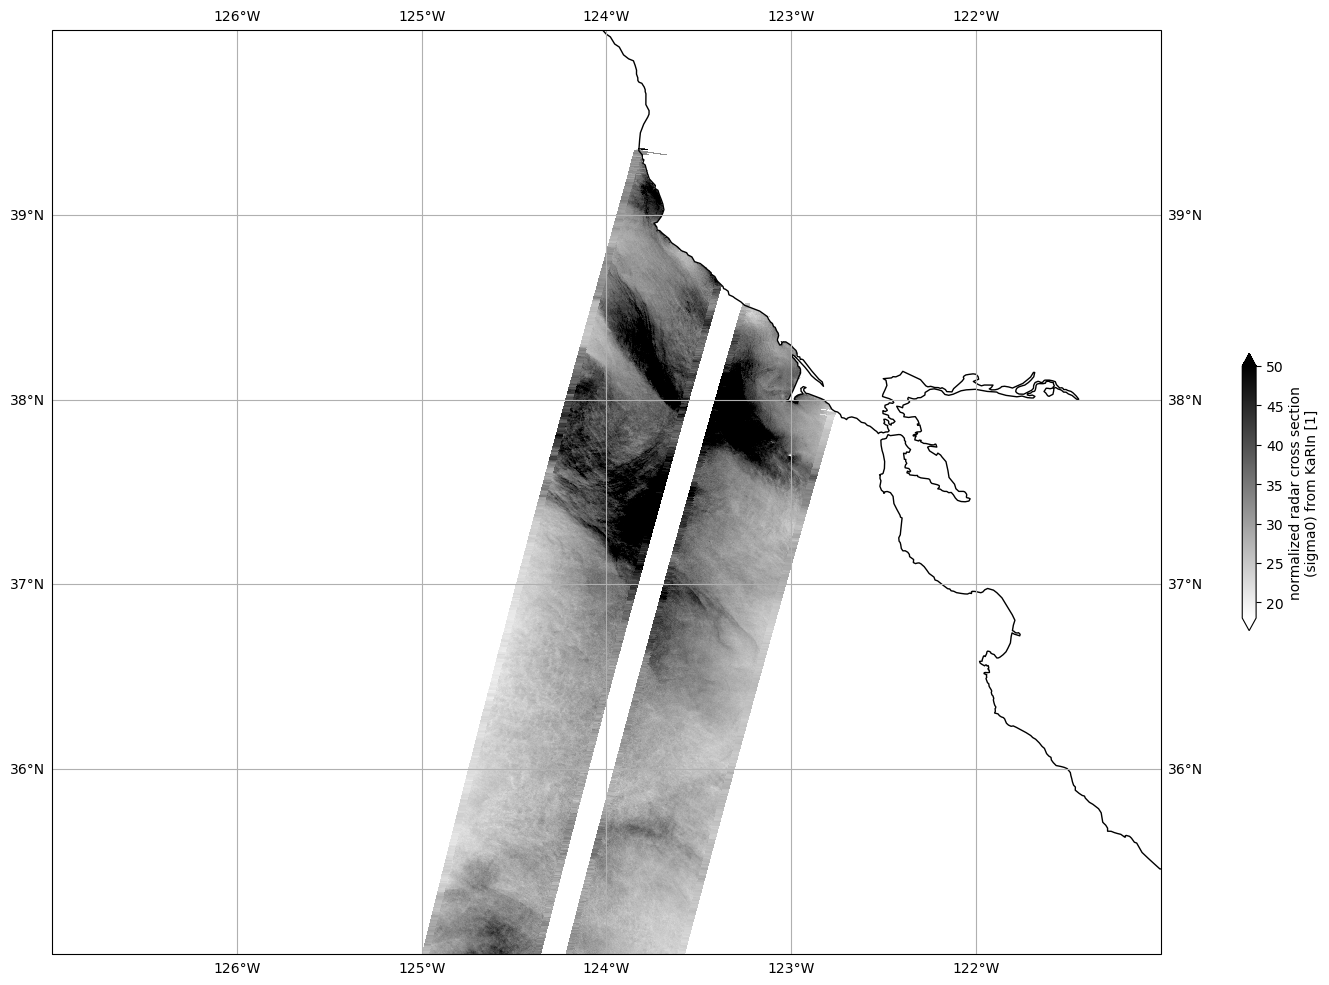

In [50]:
plot_kwargs = dict(
    x="longitude",
    y="latitude",
    cmap="gray_r",
    vmin=18,
    vmax=50,
)

fig, ax = plt.subplots(figsize=(21, 12), subplot_kw=dict(projection=ccrs.PlateCarree()))
ds_left.sig0_karin_2.plot.pcolormesh(ax=ax, cbar_kwargs={"shrink": 0.3}, **plot_kwargs)
ds_right.sig0_karin_2.plot.pcolormesh(ax=ax, add_colorbar=False, **plot_kwargs)

ax.gridlines(draw_labels=True)
ax.coastlines()
ax.set_extent([-127, -121, 35, 40], crs=ccrs.PlateCarree())

### Plot SSHA



Mask invalid data



In [48]:
for dss in ds_left, ds_right:
    dss["ssh_karin_2"] = dss.ssh_karin_2.where(dss.ancillary_surface_classification_flag==0)
    dss["ssh_karin_2"] = dss.ssh_karin_2.where(dss.ssh_karin_2_qual==0)

Plot data



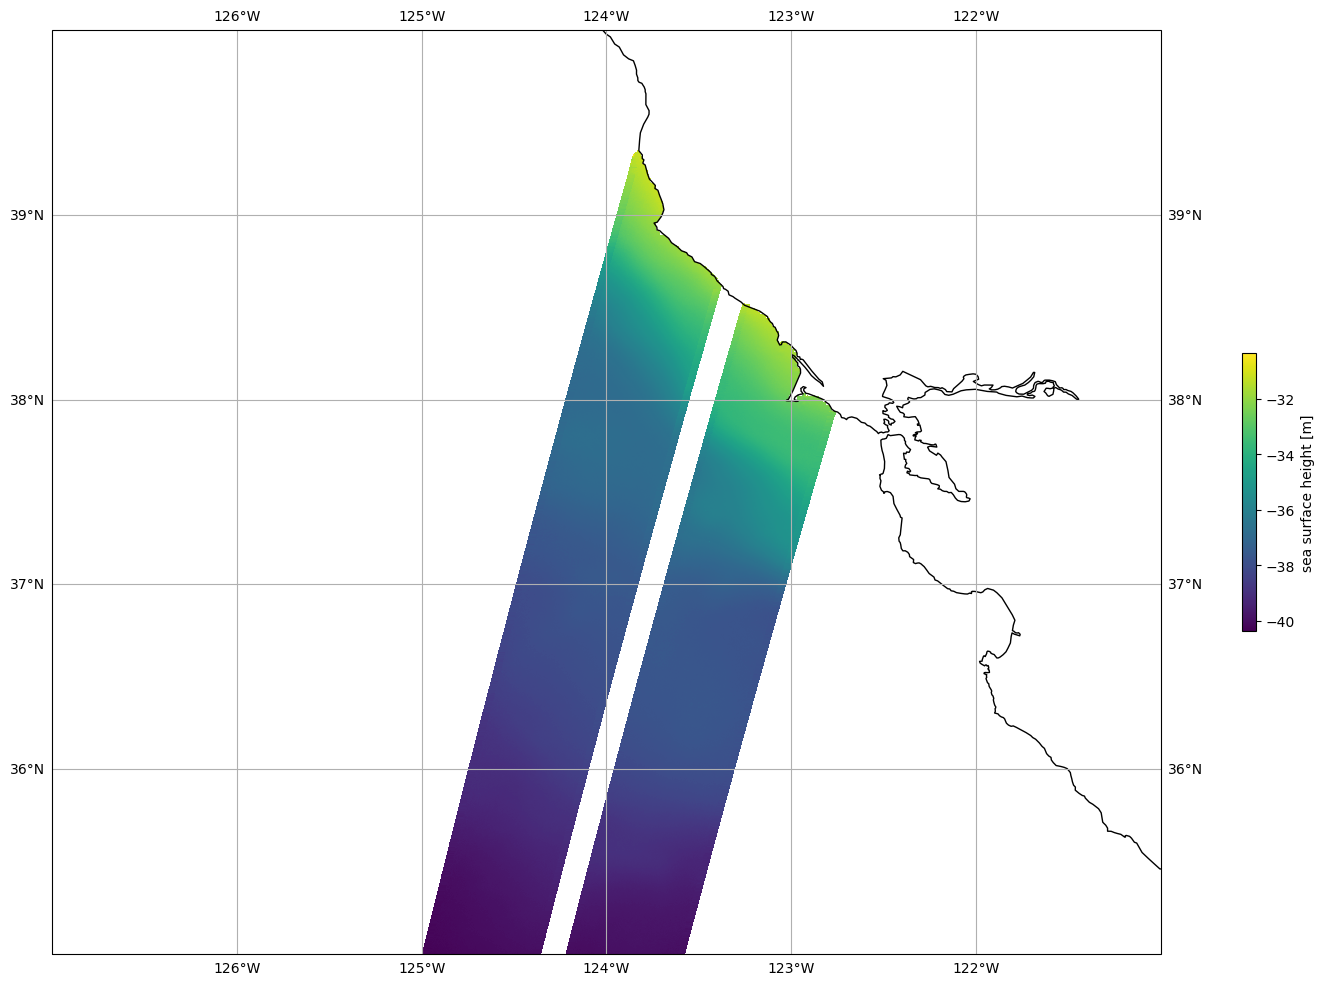

In [49]:
plot_kwargs = dict(
    x="longitude",
    y="latitude"
)

fig, ax = plt.subplots(figsize=(21, 12), subplot_kw=dict(projection=ccrs.PlateCarree()))
ds_left.ssh_karin_2.plot.pcolormesh(ax=ax, cbar_kwargs={"shrink": 0.3}, **plot_kwargs)
ds_right.ssh_karin_2.plot.pcolormesh(ax=ax, add_colorbar=False, **plot_kwargs)

ax.gridlines(draw_labels=True)
ax.coastlines()
ax.set_extent([-127, -121, 35, 40], crs=ccrs.PlateCarree())